# Анализ рекламных событий

#### Имеются данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (тех, кто разместил эти объявления).

## Описание данных:

- ***ads_data.csv – данные взаимодействий с рекламными объявлениями***:

 - **date** – дата
 - **time** – время
 - **event** – действие (просмотр/клик)
 - **platform** – платформа
 - **ad_id** – id объявления
 - **client_union_id** – id рекламного кабинета
 - **campaign_union_id** – id рекламной кампании
 - **ad_cost_type** – тип оплаты
 - **ad_cost** – цена
 - **has_video** – есть ли видео
 - **target_audience_count** – размер аудитории
 
 
- ***ads_clients_data.csv – характеристики рекламных клиентов:***
 - **date** – дата
 - **client_union_id** – id рекламного кабинета
 - **community_id** – id сообщества
 - **create_date** – дата создания рекламного клиента

## Задачи:

**1) Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).**

**2) Нарисуйте график распределения показов на объявление за весь период.**

**3) Давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?**

**4) Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем.**

**5) Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем.**

**6) Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.**

**7) Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых.**

**8) Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).**

**9) А теперь – выведем на график эти категории с количеством уникальных клиентов в них.**

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Зададим стиль графиков
sns.set(font_scale=1.5,
        style="whitegrid",
        rc={'figure.figsize':(20, 8)})

In [3]:
# Считаем данные взаимодействий по рекламным объявлениям
ads_data = pd.read_csv(r'D:\data_analysis\projects\ads_data\ads_data.csv', parse_dates=['date', 'time'])
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [4]:
# Посмотрим на размерность данных
ads_data.shape

(1000000, 11)

In [5]:
# Посмотрим есть ли пропущенные значения в данных
ads_data.isnull().sum()

date                     0
time                     0
event                    0
platform                 0
ad_id                    0
client_union_id          0
campaign_union_id        0
ad_cost_type             0
ad_cost                  0
has_video                0
target_audience_count    0
dtype: int64

#### 1. Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям.

In [6]:
# Сгруппируем данные по объявлению и событию и посчитаем число событий для каждого объявления в каждом типе
# Сделаем сводную табличку по всем типам событий и всем рекламам, заменим NA на 0 и посчитаем среднее
events_by_ads = ads_data \
                        .groupby(['ad_id', 'event'], as_index=False) \
                        .agg({'date': 'count'}) \
                        .rename(columns={'date': 'number'}) \
                        .pivot(index='ad_id', columns='event', values='number') \
                        .fillna(0).mean()

print(f'Среднее количество кликов на объявление {int(events_by_ads[0])}. \
        \nСреднее количество показов на объявление {int(events_by_ads[1])}.')

Среднее количество кликов на объявление 113.         
Среднее количество показов на объявление 923.


#### 2. Нарисуем график распределения показов на объявление за весь период:
- **по оси x – число показов**
- **по оси y – доля объявлений с такими показами**

Возьмем из прошлого задания сгруппированный по типу события и объявлению датафрэйм, где подсчитано число строк для каждой группы (то есть число таких событий для определённой рекламы). Прологарифмируем число показов, а затем построим такой график, чтобы можно было понять форму распределения.

In [7]:
all_events = ads_data \
                    .groupby(['ad_id', 'event'], as_index=False) \
                    .agg({'date': 'count'}) \
                    .rename(columns={'date': 'number'}) \
                    .pivot(index='ad_id', columns='event', values='number') \
                    .reset_index()

all_events['view'] = np.log(all_events['view'])

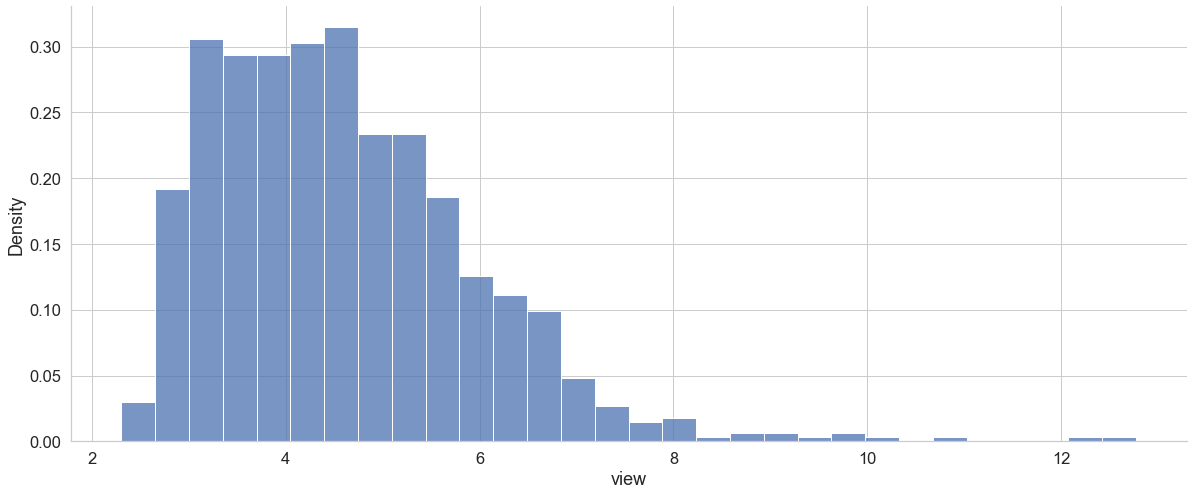

In [8]:
sns.histplot(all_events['view'], stat='density')
sns.despine()

#### 3. Найдем среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитаем скользящее среднее по полученному результату с окном в 2 элемента.

In [9]:
# Построим сводную таблицу, где колонки будут датами, а значения - количество показов каждого объявления в этот день
views_per_day = ads_data \
            .query('event == "view"') \
            .pivot_table(index='ad_id', columns='date', values='event', aggfunc='count')

views_per_day.head()

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,83.0,18.0,NaN,NaN,NaN,NaN
3,158.0,26.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,34.0,7.0,NaN,NaN
2064,NaN,28.0,7.0,NaN,NaN,NaN
2132,NaN,NaN,25.0,27.0,6.0,NaN


In [10]:
# Посчитаем среднее число показов по дням и применим функцию скользящего среднего
rolling_mean_views = views_per_day.mean().rolling(2).mean()

# Ответим на вопрос по скользящему среднему за 6.04.2019 г.
print(f'Значение скользящего среднего за 6 апреля 2019 года - {int(rolling_mean_views[-1])}.')

Значение скользящего среднего за 6 апреля 2019 года - 598.


#### 4. Построим график значения просто среднего количества показов по дням и скользящего среднего.

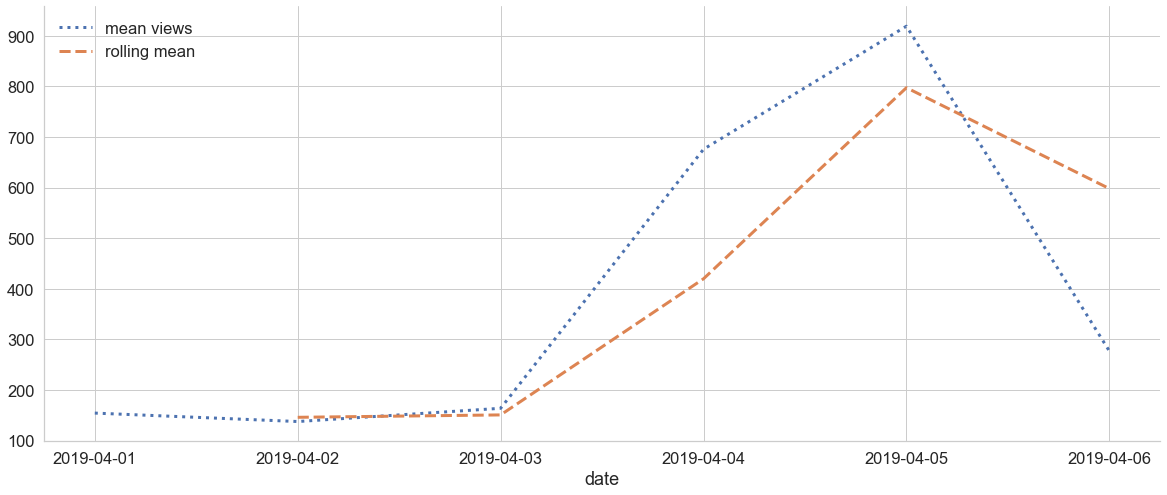

In [11]:
sns.lineplot(data=views_per_day.mean(), label='mean views', linewidth = 3, linestyle='dotted')
sns.lineplot(data=rolling_mean_views, label='rolling mean', linewidth = 3, linestyle='dashed')
plt.legend(frameon=False, loc='upper left')
sns.despine()

#### 5. Посчитаем в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним.

In [12]:
day = str(views_per_day.mean().subtract(rolling_mean_views).abs().idxmax()).split(' ')[0]
print(f'Наибольшая разница по модулю между арифметическим средним и скользящим средним наблюдается {day}.')

Наибольшая разница по модулю между арифметическим средним и скользящим средним наблюдается 2019-04-06.


#### 6. Объединим данные рекламы с данными о рекламных клиентах и найдем среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

In [13]:
# Считаем данные по характеристикам рекламных клиентов
ads_clients = pd.read_csv(r'D:\data_analysis\projects\ads_data\ads_clients_data.csv', parse_dates=['date', 'create_date'])
ads_clients.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [14]:
# Удалим нерелевантные столбцы из рекламных клиентов
ads_clients.drop(columns=['date', 'community_id'], inplace=True)
ads_clients.head(3)

,client_union_id,create_date
0,1,2018-12-24
1,2,2019-02-10
2,3,2019-01-25


In [15]:
# Объединим два датафрейма в один
ads_full = pd.merge(ads_data, ads_clients, on='client_union_id')
ads_full.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


In [16]:
# Рассчитаем среднее количество дней от даты создания рекламного клиента
ads_full \
        .groupby('client_union_id') \
        .apply(lambda x: (x.date - x.create_date).min()) \
        .mean()

Timedelta('124 days 09:04:43.532219570')

#### 7. Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

*__Конверсия__ – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов. Например, 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу. В таком случае конверсия будет равна:* 

$$\cfrac{50}{1000} * 100 = 5 \%$$

In [17]:
# Воспользуемся данными по клиентам и разницей от создания кабинета до первого запуска рекламы
time_diff = ads_full \
                .groupby('client_union_id') \
                .apply(lambda x: (x.date - x.create_date).min())

# Отберем только тех клиентов, которые совершили целевое действие в течении не более 365 дней
clients = time_diff.loc[time_diff <= '365d'].shape[0]

# Посчитаем общее количество всех клиентов
all_clients = ads_clients.client_union_id.nunique()

# Вычислим конверсию
conversion = clients/all_clients
print(f'Конверсия из создания рекламного кабинета в запуск первой рекламы в первые 365 дней - {conversion:.2%}')

Конверсия из создания рекламного кабинета в запуск первой рекламы в первые 365 дней - 0.69%


#### 8. Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления. Определим, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).

In [18]:
create_launch_periods = pd.cut(time_diff, 
                                   bins=pd.to_timedelta([0, 30, 90, 180, 365], unit='d'),
                                   labels=['0-30 days', '30-90 days', '90-180 days', '180-365 days']) \
                           .value_counts()

number = create_launch_periods['0-30 days']
print(f'В первый месяц своего существования {number} клиентов запустили свое первое объявление.')

В первый месяц своего существования 11 клиентов запустили свое первое объявление.


#### 9. Построим барплот, на котором будут показаны категории с количеством уникальных клиентов в них.

<AxesSubplot:>

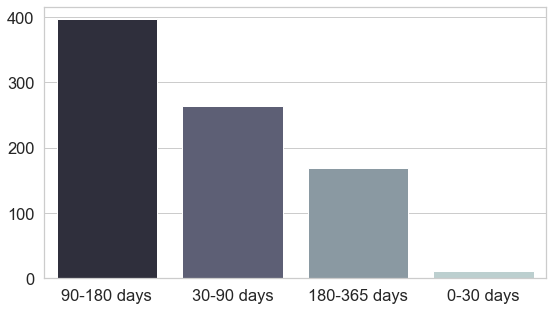

In [19]:
plt.figure(figsize=(9, 5))
x = create_launch_periods.index.tolist()
y = create_launch_periods.values.tolist()
sns.barplot(x=x, y=y, palette = 'bone')